# Create a phase curve

``squishyplanet`` can also model phase curves of triaxial planets, though admittedly, its approach is much cruder here than when modeling transit-only lightcurves. We still use the same 3D description of the planet, but then the analytics fall away and we just Monte Carlo sample the visible disk of the planet as seen from the observer at each timestep. This is both slow and memory intensive but does in theory provide for some flexibility to choose interesting reflection/emission laws. Pre-version 1.0, ``squishyplanet`` only supports uniform albedo Lambertian scattering for reflections and a single hotspot modeled by a von Mises-Fisher distribution for thermal emission, though hopefully more options will be added in the future.

``squishyplanet`` handles secondary eclipses just by masking each sample of the surface according to whether it's behind the star or not.

Finally, ``squishyplanet`` also can "model" stellar ellipsoidal variations caused by gravity-induced darkening and stellar doppler beaming effects. However, these are not super physically motivated and are just sinusoids with periods of twice and equal to the orbital period, respectively. These are scaled by a user-provided amplitude (or fitted) amplitude: these amplitudes are related to other parameters in the model (e.g. [Wong et al. 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....160...88W/abstract>)), but it's up to the user to include those relationships in a prior if they wish.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const

from squishyplanet import OblateSystem

## Reflections

[(0.9997, 1.0001), Text(0.5, 0, 'Time'), Text(0, 0.5, 'Flux')]

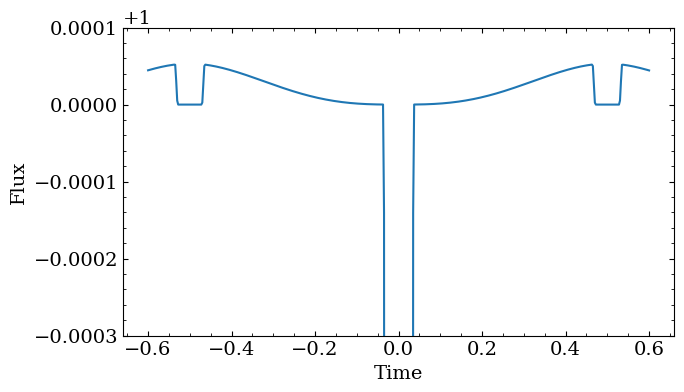

In [2]:
state = {
    "t_peri": -0.25,
    "times": jnp.linspace(-0.6, 0.6, 500),
    "a": 5.0,
    "period": 1.0,
    "r": 0.1,
    "i": jnp.pi / 2,
    "ld_u_coeffs": jnp.array([0.4, 0.26]),
    "tidally_locked": False,
    "compute_reflected_phase_curve": True,
    "albedo": 0.2,
}
planet = OblateSystem(**state)

fig, ax = plt.subplots()
ax.plot(planet.state["times"], planet.lightcurve())
w = 3e-4
ax.set(ylim=[1 - 3e-4, 1 + 1e-4], xlabel="Time", ylabel="Flux")

To estimate the noise/bias introduced by our Monte Carlo estimate, we can set an identical system with a different random seed and compare the two estimates:

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Flux difference [ppm]')]

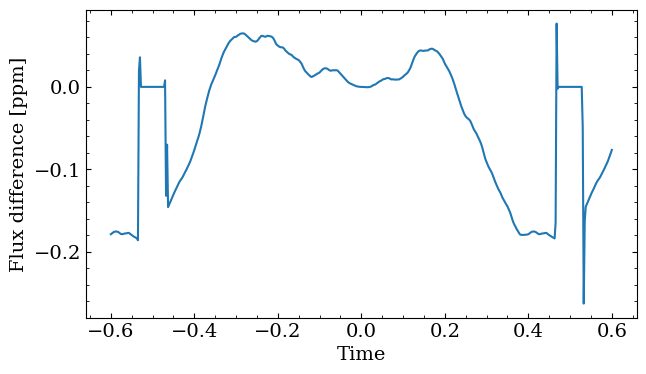

In [3]:
state = {
    "t_peri": -0.25,
    "times": jnp.linspace(-0.6, 0.6, 500),
    "a": 5.0,
    "period": 1.0,
    "r": 0.1,
    "i": jnp.pi / 2,
    "ld_u_coeffs": jnp.array([0.4, 0.26]),
    "tidally_locked": False,
    "compute_reflected_phase_curve": True,
    "albedo": 0.2,
    "random_seed": 0,
}
planet1 = OblateSystem(**state)

state["random_seed"] = 1
planet2 = OblateSystem(**state)

diff = planet1.lightcurve() - planet2.lightcurve()

fig, ax = plt.subplots()
ax.plot(planet1.state["times"], diff * 1e6)
ax.set(xlabel="Time", ylabel="Flux difference [ppm]")

Here it looks like the noise is likely acceptable with the default settings, which use 50,000 samples per timestep.

Lastly, we can compare our reflect curves of spherical planets with ``starry``'s estimate of the same system. Since as of writing ``starry`` is difficult to install due to some dependency conflicts, we pre-generated this curve using ``starry`` v1.2.0:

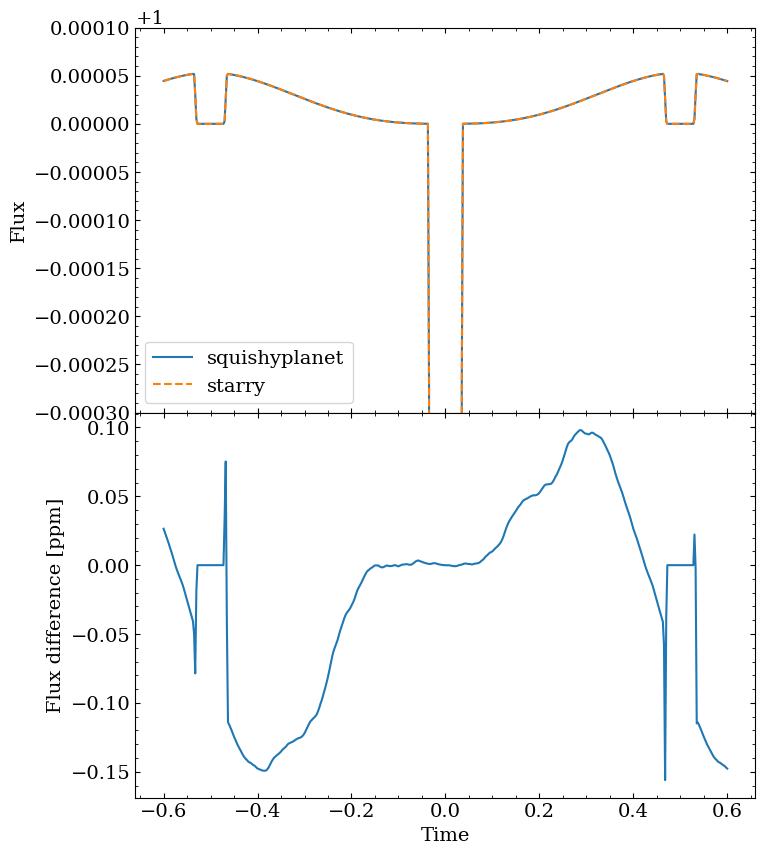

In [4]:
# import astropy.units as u
# import astropy.constants as const
# import numpy as np
# import matplotlib.pyplot as plt
# import starry
# starry.config.lazy = False
# starry.config.quiet = True
# star_mass = ((5.0*u.R_sun)**3 / (1.0*u.day)**2 / (const.G) * (4*np.pi**2)).to(u.M_sun).value
# starry.config.lazy = False
# starry.config.quiet = True
# sun = starry.Primary(starry.Map(), r=1, length_unit=u.Rsun, m=star_mass, m_unit=u.Msun)
# map = starry.Map(reflected=True)
# planet = starry.Secondary(map, a=5.0, m=0.0, inc=90, r=0.1, length_unit=u.Rsun)
# planet.map.amp = 0.2
# sys = starry.System(sun, planet)
# np.save("starry_reflected_curve.npy", sys.flux(t))

starry_flux = np.load("starry_reflected_curve.npy")


state = {
    "t_peri": -0.25,
    "times": jnp.linspace(-0.6, 0.6, 500),
    "a": 5.0,
    "period": 1.0,
    "r": 0.1,
    "i": jnp.pi / 2,
    "ld_u_coeffs": jnp.array([0.0, 0.0]),
    "tidally_locked": False,
    "compute_reflected_phase_curve": True,
    "albedo": 0.2,
}
planet = OblateSystem(**state)
lc = planet.lightcurve()

fig, axs = plt.subplots(nrows=2, figsize=(8, 10), sharex=True)
axs[0].plot(planet.state["times"], lc, label="squishyplanet")
axs[0].plot(planet.state["times"], starry_flux, ls="--", label="starry")
w = 3e-4
axs[0].set(ylim=[1 - 3e-4, 1 + 1e-4], xlabel="Time", ylabel="Flux")
axs[0].legend()

axs[1].plot(planet.state["times"], 1e6 * (lc - starry_flux))
axs[1].set(xlabel="Time", ylabel="Flux difference [ppm]")

fig.subplots_adjust(hspace=0);

## Emission only

Adding emission to the phase curve looks very similar to adding reflection. For now, ``squishyplanet`` only allows for thermal maps with a single hotspot that are modeled with a von Mises-Fisher distribution. To mimic an isothermal planet, we can set the ``hotspot_concentration`` to a very low value. 

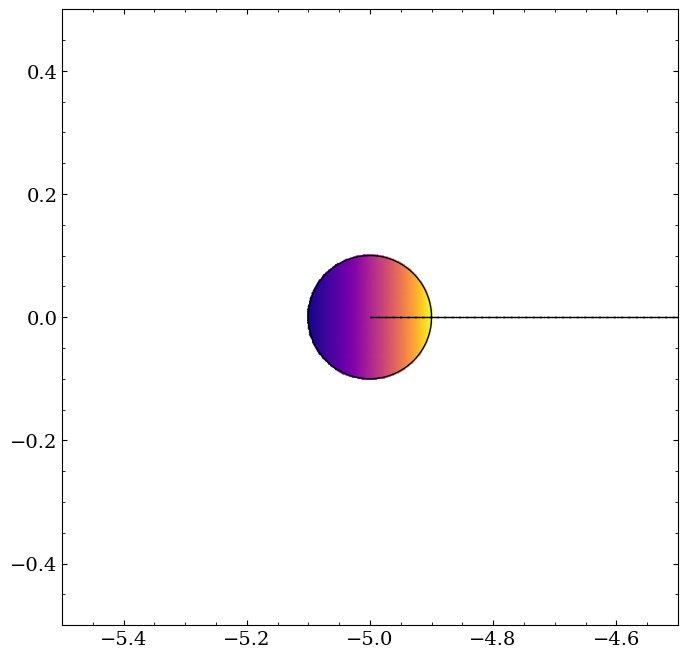

In [5]:
state = {
    "t_peri": -0.25,
    "times": jnp.linspace(-0.6, 0.6, 500),
    "a": 5.0,
    "period": 1.0,
    "r": 0.1,
    "i": jnp.pi / 2,
    "ld_u_coeffs": jnp.array([0.4, 0.26]),
    "tidally_locked": True,
    "compute_emitted_phase_curve": True,
    "hotspot_longitude": 0.0,
    "hotspot_latitude": -jnp.pi/2,
    "hotspot_concentration": 0.5,
    "emitted_scale" : 1e-4,
}
planet = OblateSystem(**state)

planet.illustrate(emitted=True, window_size=1, star_fill=False, true_anomalies=0.0)

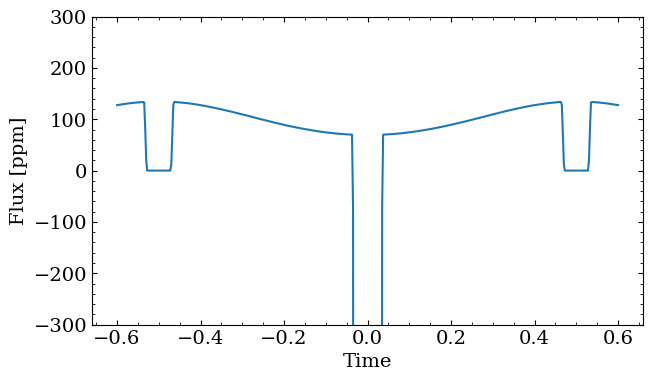

In [6]:
lc = planet.lightcurve()
fig, ax = plt.subplots()
ax.plot(planet.state["times"], (lc-1)*1e6)
w = 300
ax.set(xlabel="Time", ylabel="Flux [ppm]", ylim=[-w, w]);

We can also look at the impact of shifting the hotspot longitude away from the sub-stellar point:

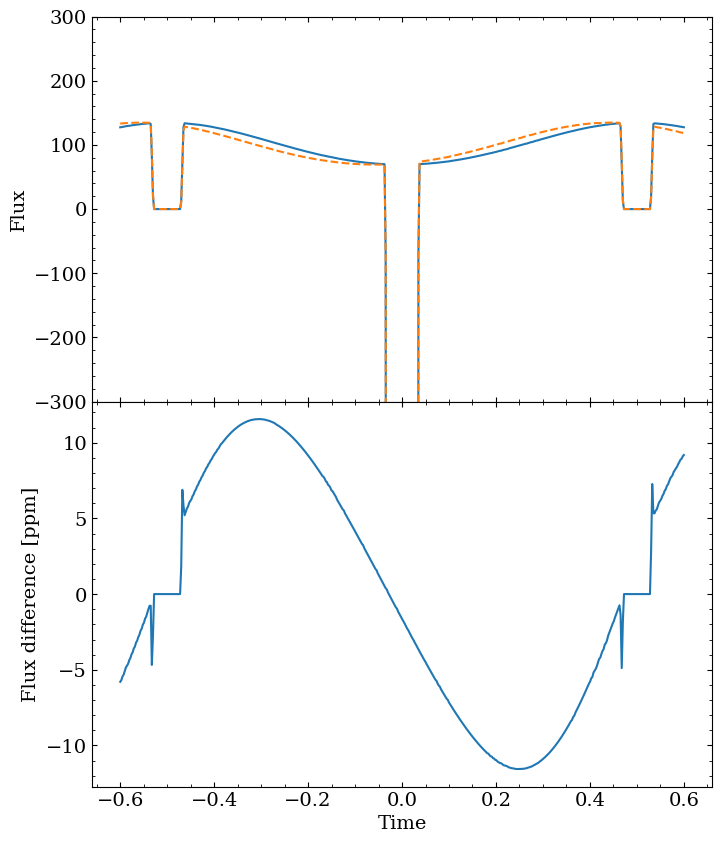

In [7]:
sub_solar = planet.lightcurve()
shifted = planet.lightcurve({"hotspot_longitude": 20*jnp.pi/180})

fig, axs = plt.subplots(nrows=2, figsize=(8, 10), sharex=True)
axs[0].plot(planet.state["times"], (sub_solar-1)*1e6, label="sub-solar hotspot")
axs[0].plot(planet.state["times"], (shifted-1)*1e6, ls="--", label="shifted hotspot")
axs[0].set(ylim=[-300, 300], xlabel="Time", ylabel="Flux")

axs[1].plot(planet.state["times"], 1e6 * (sub_solar - shifted))
axs[1].set(xlabel="Time", ylabel="Flux difference [ppm]")

fig.subplots_adjust(hspace=0);

The result is a sinusoidal difference between the two curves, plus some differences during ingress/egress of secondary eclipse. The curves agree nearly perfectly when the planet is fully blocked by the star, as expected, but still differ during primary transit. That's because their flux-blocking areas are identical, but their night-side emission is different.

## Stellar effects

``squishyplanet`` can also include two types of deviations to a standard phase curve caused by the star, not by the planet. Each of these calculations assume the planet is on a circular orbit. The first of these are "ellipsoidal variations", or variations you get from the planet's gravitational influence. This produces a sinusoidal variation with a period of half the orbital period: the hemispheres directly facing and directly opposite the planet are darker compared to the bits that are 90 degrees away from the sub-planet point in longitude:

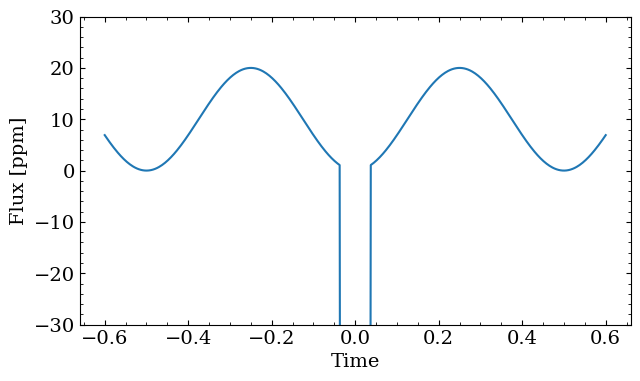

In [8]:
state = {
    "t_peri": -0.25,
    "times": jnp.linspace(-0.6, 0.6, 500),
    "a": 5.0,
    "period": 1.0,
    "r": 0.1,
    "i": jnp.pi / 2,
    "ld_u_coeffs": jnp.array([0.4, 0.26]),
    "tidally_locked": True,
    "compute_stellar_ellipsoidal_variations": True,
    "stellar_ellipsoidal_alpha":1e-5,
}
planet = OblateSystem(**state)

lc = planet.lightcurve()
fig, ax = plt.subplots()
ax.plot(planet.state["times"], (lc-1)*1e6)
w = 30
ax.set(xlabel="Time", ylabel="Flux [ppm]", ylim=[-w, w]);

Note we don't see a secondary eclipse here since we've left ``compute_emitted_phase_curve`` and ``compute_reflected_phase_curve`` as ``False``. 

The second effect is the "beaming" effect, which is a relativistic effect that causes the star to appear brighter when it's moving towards us and dimmer when it's moving away. This effect is also sinusoidal, but with a period equal to the orbital period:

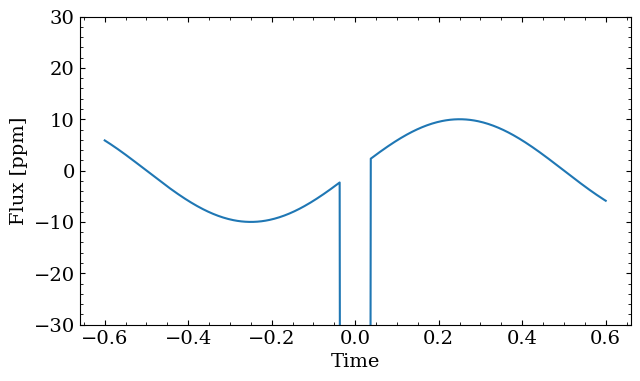

In [9]:
state = {
    "t_peri": -0.25,
    "times": jnp.linspace(-0.6, 0.6, 500),
    "a": 5.0,
    "period": 1.0,
    "r": 0.1,
    "i": jnp.pi / 2,
    "ld_u_coeffs": jnp.array([0.4, 0.26]),
    "tidally_locked": True,
    "compute_stellar_doppler_variations": True,
    "stellar_doppler_alpha":1e-5,
}
planet = OblateSystem(**state)

lc = planet.lightcurve()
fig, ax = plt.subplots()
ax.plot(planet.state["times"], (lc-1)*1e6)
w = 30
ax.set(xlabel="Time", ylabel="Flux [ppm]", ylim=[-w, w]);

Here the star is dimmer as it moves away, then brighter as it moves towards, the observer.

## All combined

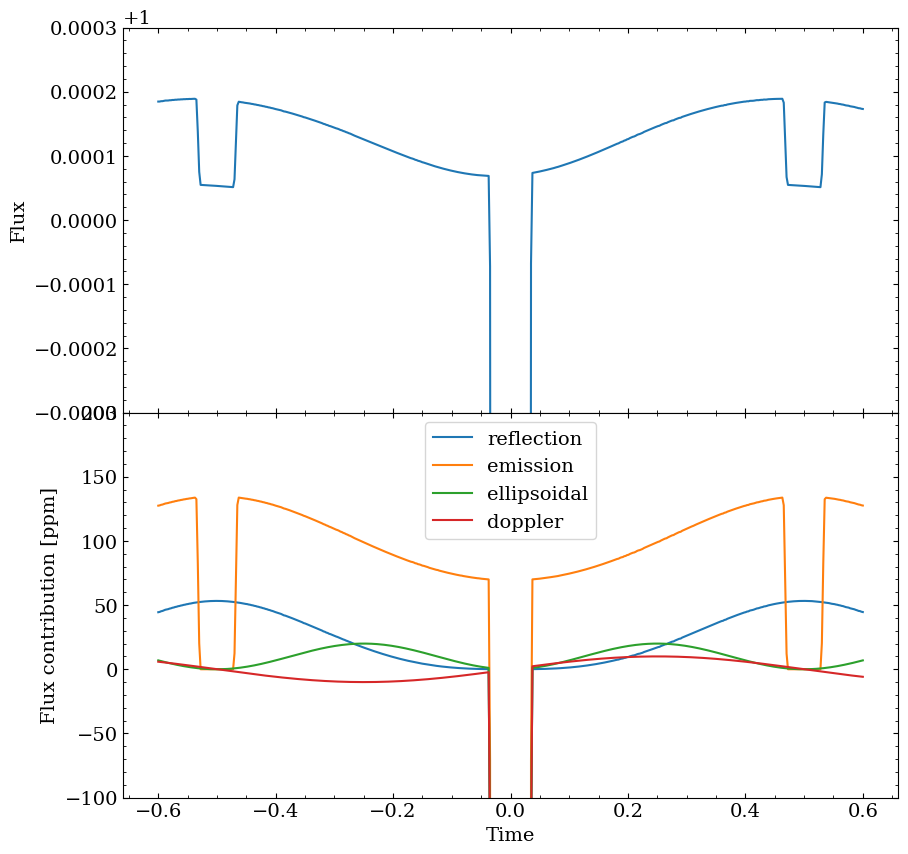

In [10]:
state = {
    "t_peri": -0.25,
    "times": jnp.linspace(-0.6, 0.6, 500),
    "a": 5.0,
    "period": 1.0,
    "r": 0.1,
    "i": jnp.pi / 2,
    "ld_u_coeffs": jnp.array([0.4, 0.26]),
    "tidally_locked": True,
    "compute_reflected_phase_curve": True,
    "compute_emitted_phase_curve": True,
    "compute_stellar_ellipsoidal_variations": True,
    "compute_stellar_doppler_variations": True,
    "albedo": 0.2,
    "hotspot_longitude": 0.0,
    "hotspot_latitude": -jnp.pi/2,
    "hotspot_concentration": 0.5,
    "emitted_scale" : 1e-4,
    "stellar_ellipsoidal_alpha":1e-5,
    "stellar_doppler_alpha":1e-5,
    "random_seed": 0,
}

planet = OblateSystem(**state)
lc = planet.lightcurve()

fig, axs = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)
axs[0].plot(planet.state["times"], lc)
w = 3e-4
axs[0].set(ylim=[1 - w, 1 + w], ylabel="Flux")


zeroed_out = {
    "albedo": 0.0,
    "emitted_scale": 0.0,
    "stellar_ellipsoidal_alpha": 0.0,
    "stellar_doppler_alpha": 0.0,
}
reflection_only = zeroed_out.copy()
reflection_only["albedo"] = 0.2
axs[1].plot(planet.state["times"], (planet.lightcurve(reflection_only)-1)*1e6, label="reflection")

emission_only = zeroed_out.copy()
emission_only["emitted_scale"] = 1e-4
axs[1].plot(planet.state["times"], (planet.lightcurve(emission_only)-1)*1e6, label="emission")

ellipsoidal_only = zeroed_out.copy()
ellipsoidal_only["stellar_ellipsoidal_alpha"] = 1e-5
axs[1].plot(planet.state["times"], (planet.lightcurve(ellipsoidal_only)-1)*1e6, label="ellipsoidal")

doppler_only = zeroed_out.copy()
doppler_only["stellar_doppler_alpha"] = 1e-5
axs[1].plot(planet.state["times"], (planet.lightcurve(doppler_only)-1)*1e6, label="doppler")

axs[1].legend()
axs[1].set(xlabel="Time", ylabel="Flux contribution [ppm]", ylim=[-100, 200])

fig.subplots_adjust(hspace=0);

## Extended emission

In progress!